# Dataset Analysis

🚀 Setting up Comprehensive Vision Pipeline...
🔍 Starting Dataset Analysis...
📁 Found 4 classes: ['Angry+Disgusted', 'Happy', 'Neutral', 'Sad']
  📊 Angry+Disgusted: 40 images
  📊 Happy: 82 images
  📊 Neutral: 73 images
  📊 Sad: 31 images

📈 Dataset Statistics:
  Total images: 226
  Class balance ratio: 0.378
⚠️  Warning: Significant class imbalance detected!

🖼️  Analyzing Image Properties...


Processing images: 100%|██████████| 226/226 [00:00<00:00, 3768.30it/s]

📏 Image Dimensions:
  Width - Min: 3336, Max: 6000, Mean: 5229.2
  Height - Min: 2160, Max: 4000, Mean: 3405.7
🎨 Formats: {'MPO': 145, 'JPEG': 81}
🌈 Color Modes: {'RGB': 226}
💾 File Sizes (KB) - Min: 1897.1, Max: 11228.9, Mean: 6134.6


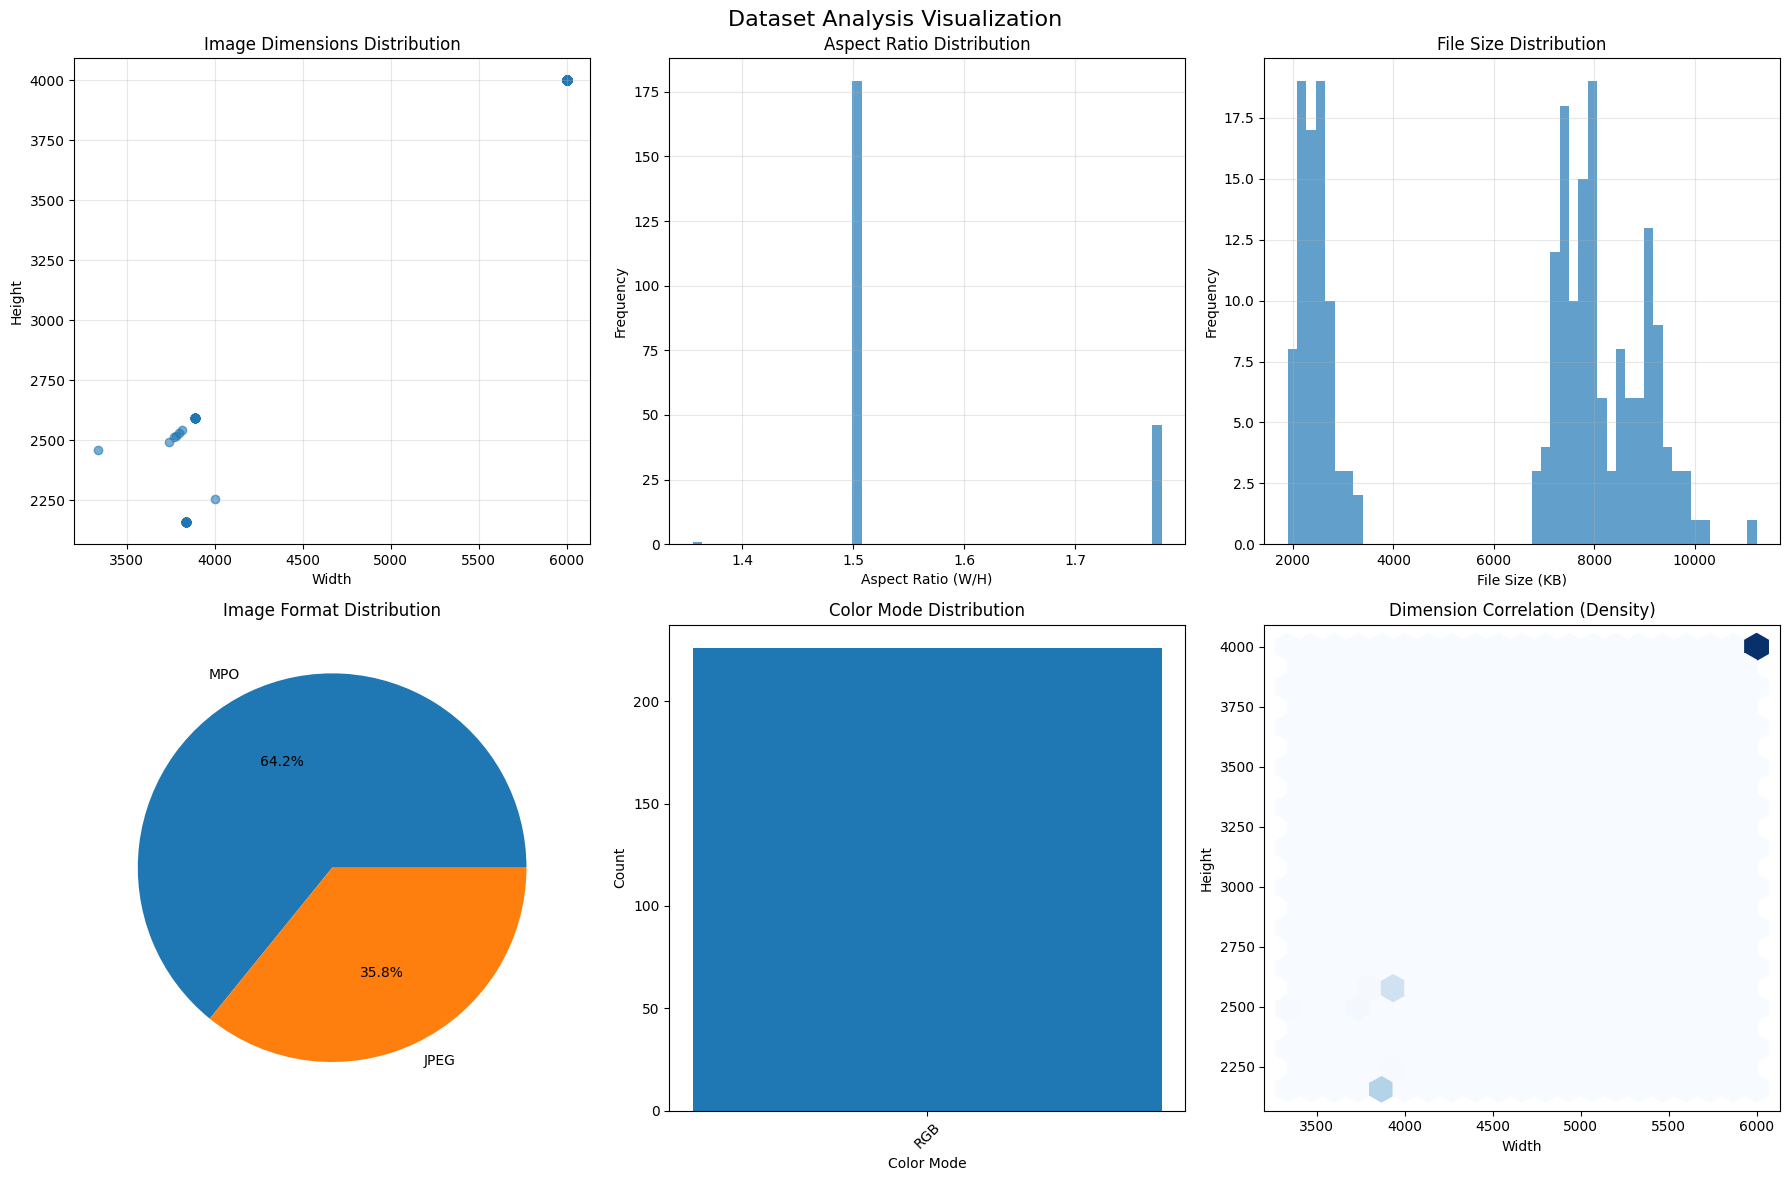

Validating images: 100%|██████████| 226/226 [00:17<00:00, 12.94it/s]


✅ Cleaned dataset: 226 valid images, 0 removed

✅ Pipeline Setup Complete!
📊 Dataset Split:
  Train: 158 samples
  Validation: 34 samples
  Test: 34 samples
🏷️  Classes (4): ['Angry+Disgusted', 'Happy', 'Neutral', 'Sad']

🧪 Testing Pipeline...
Batch 0: Data shape torch.Size([32, 3, 224, 224]), Target shape torch.Size([32])
Batch 1: Data shape torch.Size([32, 3, 224, 224]), Target shape torch.Size([32])
Batch 2: Data shape torch.Size([32, 3, 224, 224]), Target shape torch.Size([32])
🎉 Pipeline ready for training!


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms
from PIL import Image, ImageFile
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import cv2
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
from pathlib import Path
import json
from tqdm import tqdm
import logging
import multiprocessing

# Fix for Windows multiprocessing
if __name__ == '__main__':
    multiprocessing.set_start_method('spawn', force=True)

# Enable loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

class VisionDataAnalyzer:
    def __init__(self, data_dir, target_size=(224, 224)):
        self.data_dir = Path(data_dir)
        self.target_size = target_size
        self.class_names = []
        self.class_to_idx = {}
        self.image_stats = defaultdict(list)
        self.corrupted_files = []
        
        # Setup logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
    def analyze_dataset(self):
        """Comprehensive dataset analysis"""
        print("🔍 Starting Dataset Analysis...")
        
        # Get class information
        self.class_names = [d.name for d in self.data_dir.iterdir() if d.is_dir()]
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}
        
        print(f"📁 Found {len(self.class_names)} classes: {self.class_names}")
        
        # Analyze each class
        class_stats = {}
        total_images = 0
        
        for class_name in self.class_names:
            class_path = self.data_dir / class_name
            image_files = list(class_path.glob('*'))
            
            # Filter valid image files
            valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
            image_files = [f for f in image_files if f.suffix.lower() in valid_extensions]
            
            class_stats[class_name] = {
                'count': len(image_files),
                'files': image_files
            }
            total_images += len(image_files)
            
            print(f"  📊 {class_name}: {len(image_files)} images")
        
        # Check class balance
        counts = [stats['count'] for stats in class_stats.values()]
        balance_ratio = min(counts) / max(counts) if max(counts) > 0 else 0
        
        print(f"\n📈 Dataset Statistics:")
        print(f"  Total images: {total_images}")
        print(f"  Class balance ratio: {balance_ratio:.3f}")
        
        if balance_ratio < 0.5:
            print("⚠️  Warning: Significant class imbalance detected!")
        
        # Analyze image properties
        self._analyze_image_properties(class_stats)
        
        return class_stats
    
    def _analyze_image_properties(self, class_stats):
        """Analyze image dimensions, formats, and quality"""
        print("\n🖼️  Analyzing Image Properties...")
        
        all_widths, all_heights = [], []
        format_counts = Counter()
        mode_counts = Counter()
        file_sizes = []
        
        total_files = sum(len(stats['files']) for stats in class_stats.values())
        
        with tqdm(total=total_files, desc="Processing images") as pbar:
            for class_name, stats in class_stats.items():
                for img_path in stats['files']:
                    try:
                        with Image.open(img_path) as img:
                            all_widths.append(img.width)
                            all_heights.append(img.height)
                            format_counts[img.format] += 1
                            mode_counts[img.mode] += 1
                            file_sizes.append(img_path.stat().st_size / 1024)  # KB
                            
                    except Exception as e:
                        self.corrupted_files.append(str(img_path))
                        self.logger.warning(f"Corrupted file: {img_path} - {e}")
                    
                    pbar.update(1)
        
        # Calculate statistics
        self.image_stats = {
            'widths': all_widths,
            'heights': all_heights,
            'formats': dict(format_counts),
            'modes': dict(mode_counts),
            'file_sizes_kb': file_sizes
        }
        
        print(f"📏 Image Dimensions:")
        print(f"  Width - Min: {min(all_widths)}, Max: {max(all_widths)}, Mean: {np.mean(all_widths):.1f}")
        print(f"  Height - Min: {min(all_heights)}, Max: {max(all_heights)}, Mean: {np.mean(all_heights):.1f}")
        print(f"🎨 Formats: {dict(format_counts)}")
        print(f"🌈 Color Modes: {dict(mode_counts)}")
        print(f"💾 File Sizes (KB) - Min: {min(file_sizes):.1f}, Max: {max(file_sizes):.1f}, Mean: {np.mean(file_sizes):.1f}")
        
        if self.corrupted_files:
            print(f"❌ Found {len(self.corrupted_files)} corrupted files")
    
    def visualize_analysis(self):
        """Create visualization plots for dataset analysis"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Dataset Analysis Visualization', fontsize=16)
        
        # Image dimensions scatter plot
        axes[0, 0].scatter(self.image_stats['widths'], self.image_stats['heights'], alpha=0.6)
        axes[0, 0].set_xlabel('Width')
        axes[0, 0].set_ylabel('Height')
        axes[0, 0].set_title('Image Dimensions Distribution')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Aspect ratio histogram
        aspect_ratios = np.array(self.image_stats['widths']) / np.array(self.image_stats['heights'])
        axes[0, 1].hist(aspect_ratios, bins=50, alpha=0.7)
        axes[0, 1].set_xlabel('Aspect Ratio (W/H)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Aspect Ratio Distribution')
        axes[0, 1].grid(True, alpha=0.3)
        
        # File size distribution
        axes[0, 2].hist(self.image_stats['file_sizes_kb'], bins=50, alpha=0.7)
        axes[0, 2].set_xlabel('File Size (KB)')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].set_title('File Size Distribution')
        axes[0, 2].grid(True, alpha=0.3)
        
        # Format distribution
        formats = list(self.image_stats['formats'].keys())
        counts = list(self.image_stats['formats'].values())
        axes[1, 0].pie(counts, labels=formats, autopct='%1.1f%%')
        axes[1, 0].set_title('Image Format Distribution')
        
        # Color mode distribution
        modes = list(self.image_stats['modes'].keys())
        mode_counts = list(self.image_stats['modes'].values())
        axes[1, 1].bar(modes, mode_counts)
        axes[1, 1].set_xlabel('Color Mode')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_title('Color Mode Distribution')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        # Width vs Height correlation
        axes[1, 2].hexbin(self.image_stats['widths'], self.image_stats['heights'], gridsize=20, cmap='Blues')
        axes[1, 2].set_xlabel('Width')
        axes[1, 2].set_ylabel('Height')
        axes[1, 2].set_title('Dimension Correlation (Density)')
        
        plt.tight_layout()
        plt.show()

class AdvancedImageDataset(datasets.ImageFolder):
    """Enhanced ImageFolder with advanced preprocessing and error handling"""
    
    def __init__(self, root, transform=None, target_transform=None, 
                 cleanup_corrupted=True, min_size=(32, 32)):
        self.cleanup_corrupted = cleanup_corrupted
        self.min_size = min_size
        self.corrupted_files = []
        
        super().__init__(root, transform, target_transform)
        
        if cleanup_corrupted:
            self._cleanup_dataset()
    
    def _cleanup_dataset(self):
        """Remove corrupted or invalid images"""
        valid_samples = []
        
        for path, class_idx in tqdm(self.samples, desc="Validating images"):
            try:
                with Image.open(path) as img:
                    # Check minimum size
                    if img.width >= self.min_size[0] and img.height >= self.min_size[1]:
                        # Try to load the image data
                        img.load()
                        valid_samples.append((path, class_idx))
                    else:
                        self.corrupted_files.append(path)
            except Exception as e:
                self.corrupted_files.append(path)
        
        self.samples = valid_samples
        print(f"✅ Cleaned dataset: {len(valid_samples)} valid images, {len(self.corrupted_files)} removed")

class VisionPreprocessor:
    def __init__(self, input_size=(224, 224), mean=None, std=None):
        self.input_size = input_size
        self.mean = mean or [0.485, 0.456, 0.406]  # ImageNet defaults
        self.std = std or [0.229, 0.224, 0.225]
        
    def get_transforms(self, phase='train', augmentation_level='medium'):
        """Get comprehensive transforms for different phases"""
        
        base_transforms = [
            transforms.Resize(self.input_size),
        ]
        
        if phase == 'train':
            aug_transforms = self._get_augmentation_transforms(augmentation_level)
            base_transforms.extend(aug_transforms)
        
        # Final transforms
        final_transforms = [
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean, std=self.std)
        ]
        
        return transforms.Compose(base_transforms + final_transforms)
    
    def _get_augmentation_transforms(self, level):
        """Get augmentation transforms based on level"""
        
        if level == 'light':
            return [
                transforms.RandomHorizontalFlip(0.3),
                transforms.RandomRotation(5),
            ]
        
        elif level == 'medium':
            return [
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            ]
        
        elif level == 'heavy':
            return [
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomVerticalFlip(0.2),
                transforms.RandomRotation(30),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.8, 1.2)),
                transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
                transforms.RandomErasing(p=0.2, scale=(0.02, 0.33)),
            ]
        
        else:
            return []

class StratifiedDataSplitter:
    """Stratified splitting to maintain class balance across splits"""
    
    def __init__(self, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.random_state = random_state
    
    def split_dataset(self, dataset):
        """Create stratified splits maintaining class balance"""
        
        # Get labels for stratification
        labels = [dataset.samples[i][1] for i in range(len(dataset))]
        indices = list(range(len(dataset)))
        
        # First split: train vs (val + test)
        splitter1 = StratifiedShuffleSplit(
            n_splits=1, 
            train_size=self.train_ratio,
            random_state=self.random_state
        )
        train_idx, temp_idx = next(splitter1.split(indices, labels))
        
        # Second split: val vs test
        temp_labels = [labels[i] for i in temp_idx]
        val_ratio_adjusted = self.val_ratio / (self.val_ratio + self.test_ratio)
        
        splitter2 = StratifiedShuffleSplit(
            n_splits=1,
            train_size=val_ratio_adjusted,
            random_state=self.random_state
        )
        val_idx_temp, test_idx_temp = next(splitter2.split(temp_idx, temp_labels))
        
        # Map back to original indices
        val_idx = [temp_idx[i] for i in val_idx_temp]
        test_idx = [temp_idx[i] for i in test_idx_temp]
        
        return train_idx, val_idx, test_idx

def create_balanced_sampler(dataset, indices):
    """Create weighted sampler for handling class imbalance"""
    
    # Calculate class weights
    labels = [dataset.samples[i][1] for i in indices]
    class_counts = Counter(labels)
    total_samples = len(labels)
    
    # Inverse frequency weighting
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    
    # Create sample weights
    sample_weights = [class_weights[dataset.samples[i][1]] for i in indices]
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

def setup_comprehensive_pipeline(data_dir, 
                                input_size=(224, 224),
                                batch_size=32,
                                num_workers=0,  # Set to 0 for Windows compatibility
                                augmentation_level='medium',
                                handle_imbalance=True,
                                analyze_data=True):
    """
    Complete pipeline setup with analysis and preprocessing
    """
    
    print("🚀 Setting up Comprehensive Vision Pipeline...")
    
    # Step 1: Dataset Analysis
    if analyze_data:
        analyzer = VisionDataAnalyzer(data_dir, input_size)
        class_stats = analyzer.analyze_dataset()
        analyzer.visualize_analysis()
    
    # Step 2: Setup preprocessing
    preprocessor = VisionPreprocessor(input_size)
    
    # Step 3: Create datasets with cleanup
    train_transform = preprocessor.get_transforms('train', augmentation_level)
    val_test_transform = preprocessor.get_transforms('val')
    
    # Create base dataset for splitting
    base_dataset = AdvancedImageDataset(data_dir, transform=train_transform)
    
    # Step 4: Stratified splitting
    splitter = StratifiedDataSplitter()
    train_idx, val_idx, test_idx = splitter.split_dataset(base_dataset)
    
    # Create subset datasets
    train_dataset = torch.utils.data.Subset(base_dataset, train_idx)
    val_dataset = torch.utils.data.Subset(base_dataset, val_idx)
    test_dataset = torch.utils.data.Subset(base_dataset, test_idx)
    
    # Apply different transforms to validation and test
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform
    
    # Step 5: Create samplers and dataloaders
    train_sampler = None
    if handle_imbalance:
        train_sampler = create_balanced_sampler(base_dataset, train_idx)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        shuffle=(train_sampler is None),
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available()
    )
    
    # Step 6: Dataset information
    class_names = base_dataset.classes
    num_classes = len(class_names)
    
    print(f"\n✅ Pipeline Setup Complete!")
    print(f"📊 Dataset Split:")
    print(f"  Train: {len(train_idx)} samples")
    print(f"  Validation: {len(val_idx)} samples") 
    print(f"  Test: {len(test_idx)} samples")
    print(f"🏷️  Classes ({num_classes}): {class_names}")
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'class_names': class_names,
        'num_classes': num_classes,
        'train_indices': train_idx,
        'val_indices': val_idx,
        'test_indices': test_idx
    }

# Usage Example
if __name__ == "__main__":
    # Fix for Windows multiprocessing
    multiprocessing.set_start_method('spawn', force=True)
    
    # Setup the pipeline
    pipeline_data = setup_comprehensive_pipeline(
        data_dir="../ASD_NET_DATASET",
        input_size=(224, 224),
        batch_size=32,
        num_workers=0,  # Use 0 on Windows, 2-4 on Linux/Mac
        augmentation_level='medium',  # 'light', 'medium', 'heavy'
        handle_imbalance=True,
        analyze_data=True
    )
    
    # Access components
    train_loader = pipeline_data['train_loader']
    val_loader = pipeline_data['val_loader']
    test_loader = pipeline_data['test_loader']
    
    # Test the pipeline
    print("\n🧪 Testing Pipeline...")
    for batch_idx, (data, target) in enumerate(train_loader):
        print(f"Batch {batch_idx}: Data shape {data.shape}, Target shape {target.shape}")
        if batch_idx >= 2:  # Just test first few batches
            break
    
    print("🎉 Pipeline ready for training!")

# Device Setup

In [3]:
# Prints the installed versions of Python, NumPy, and PyTorch libraries
import sys
import numpy as np
import torch
print(f"Python Version: {sys.version}")
print(f"NumPy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")

# Function to check GPU availability and display memory statistics using PyTorch's CUDA interface
def check_gpu_status():
    # Check if GPU is available
    if torch.cuda.is_available():
        print(f"CUDA is available. PyTorch is using GPU.\n")
        # Get the number of available GPUs
        num_gpus = torch.cuda.device_count()
        print(f"Number of GPUs available: {num_gpus}")
        # Loop through each GPU and display its details
        for gpu_id in range(num_gpus):
            gpu_name = torch.cuda.get_device_name(gpu_id)
            gpu_memory_allocated = torch.cuda.memory_allocated(gpu_id) / (1024 ** 3)  # In GB
            gpu_memory_cached = torch.cuda.memory_reserved(gpu_id) / (1024 ** 3)      # In GB
            gpu_memory_total = torch.cuda.get_device_properties(gpu_id).total_memory / (1024 ** 3)  # In GB
            print(f"\nGPU {gpu_id}: {gpu_name}")
            print(f"  Total Memory: {gpu_memory_total:.2f} GB")
            print(f"  Memory Allocated: {gpu_memory_allocated:.2f} GB")
            print(f"  Memory Reserved (Cached): {gpu_memory_cached:.2f} GB")
    else:
        print("CUDA is not available. PyTorch is using the CPU.")

# Run the GPU status check
check_gpu_status()

Python Version: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
NumPy Version: 2.1.2
PyTorch Version: 2.7.1+cu118
CUDA is available. PyTorch is using GPU.

Number of GPUs available: 1

GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU
  Total Memory: 8.00 GB
  Memory Allocated: 0.00 GB
  Memory Reserved (Cached): 0.00 GB


<h2 align="center">VGG16 Model training</h2>

In [7]:
# Written by Ovi, 2024-11-11
# Image classification pipeline using VGG16
# Adapted for emotion classification dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import time
import numpy as np
import random
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Ensure reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

# Hyperparameters
batch_sizes = [16, 32]  # Adjusted for smaller dataset
learning_rates = [0.0001, 0.0005, 0.001]
epoch_counts = [20]
NUM_CLASSES = 4  # Changed from 9 to 4 classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the existing pipeline data loaders
# Assuming pipeline_data is available from the previous setup
def train_with_existing_pipeline(pipeline_data):
    
    train_loader = pipeline_data['train_loader']
    val_loader = pipeline_data['val_loader']
    test_loader = pipeline_data['test_loader']
    class_names = pipeline_data['class_names']
    
    logger.info(f"Training dataset size: {len(train_loader.dataset)}")
    logger.info(f"Validation dataset size: {len(val_loader.dataset)}")
    logger.info(f"Test dataset size: {len(test_loader.dataset)}")
    
    def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
        train_acc_history, val_acc_history = [], []
        train_loss_history, val_loss_history = [], []
        total_training_time = 0
        for epoch in range(epochs):
            epoch_start_time = time.time()
            model.train()
            train_loss = 0
            train_correct = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                train_correct += torch.sum(preds == labels.data)

            train_loss /= len(train_loader.dataset)
            train_acc = train_correct.double() / len(train_loader.dataset)
            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc.cpu())

            logger.info(f"Epoch {epoch + 1}/{epochs} - Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

            model.eval()
            val_loss = 0
            val_correct = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    val_correct += torch.sum(preds == labels.data)

            val_loss /= len(val_loader.dataset)
            val_acc = val_correct.double() / len(val_loader.dataset)
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc.cpu())

            epoch_time = time.time() - epoch_start_time
            total_training_time += epoch_time

            logger.info(f"Epoch {epoch + 1}/{epochs} - Validation: Loss = {val_loss:.4f}, Accuracy = {val_acc:.4f}")
            logger.info(f"Time for epoch {epoch + 1}: {epoch_time:.2f}s")

        logger.info(f"Total Training Time: {total_training_time:.2f}s")

        return train_acc_history, val_acc_history, train_loss_history, val_loss_history

    for batch_size in batch_sizes:
        for lr in learning_rates:
            for epochs in epoch_counts:
                logger.info(f"Training with Batch Size: {batch_size}, Learning Rate: {lr}, Epochs: {epochs}")

                model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
                for param in model.features.parameters():
                    param.requires_grad = False  # Freeze conv layers
                model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
                model = model.to(DEVICE)

                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

                train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_and_validate(
                    model, train_loader, val_loader, criterion, optimizer, epochs
                )

                epochs_range = range(1, epochs + 1)
                plt.figure()
                plt.plot(epochs_range, train_acc_history, label='Training Accuracy')
                plt.plot(epochs_range, val_acc_history, label='Validation Accuracy')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.title(f'Emotion Classification VGG16 Accuracy (Batch Size {batch_size}, LR {lr}, Epochs {epochs})')
                plt.legend()
                plt.savefig(f'emotion_vgg16_accuracy_batch_{batch_size}_lr_{lr}_epochs_{epochs}.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
                plt.close()

                plt.figure()
                plt.plot(epochs_range, train_loss_history, label='Training Loss')
                plt.plot(epochs_range, val_loss_history, label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Emotion Classification VGG16 Loss (Batch Size {batch_size}, LR {lr}, Epochs {epochs})')
                plt.legend()
                plt.savefig(f'emotion_vgg16_loss_batch_{batch_size}_lr_{lr}_epochs_{epochs}.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
                plt.close()

                def test_and_evaluate(model, test_loader, class_names):
                    model.eval()
                    all_labels = []
                    all_preds = []

                    with torch.no_grad():
                        for inputs, labels in test_loader:
                            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            all_labels.extend(labels.cpu().numpy())
                            all_preds.extend(preds.cpu().numpy())

                    macro_f1 = f1_score(all_labels, all_preds, average='macro')
                    logger.info(f"Macro-Averaged F1 Score: {macro_f1:.4f}")

                    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=np.unique(all_labels))
                    metrics_df = np.array([precision, recall, f1]).T
                    plt.figure(figsize=(8, 6))
                    sns.heatmap(metrics_df, annot=True, cmap="viridis", xticklabels=["Precision", "Recall", "F1"], yticklabels=class_names)
                    plt.title("Emotion Classification VGG16 Classification Report")
                    plt.xlabel("Metric")
                    plt.ylabel("Class")
                    plt.savefig('emotion_vgg16_classification_report.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
                    plt.close()

                    cm = confusion_matrix(all_labels, all_preds)
                    plt.figure(figsize=(10, 8))
                    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
                    plt.xlabel("Predicted Label")
                    plt.ylabel("True Label")
                    plt.title("Emotion Classification VGG16 Confusion Matrix")
                    plt.savefig('emotion_vgg16_confusion_matrix.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
                    plt.close()

                    all_labels_binarized = label_binarize(all_labels, classes=np.arange(NUM_CLASSES))
                    all_preds_binarized = np.eye(NUM_CLASSES)[np.array(all_preds)]

                    plt.figure(figsize=(10, 8))
                    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
                    for i, color in zip(range(NUM_CLASSES), colors):
                        fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_preds_binarized[:, i])
                        roc_auc = auc(fpr, tpr)
                        plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Emotion Classification VGG16 ROC Curves for All Classes')
                    plt.legend(loc="lower right")
                    plt.savefig('emotion_vgg16_ROC_All_Classes.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
                    plt.close()

                test_and_evaluate(model, test_loader, class_names=class_names)

                torch.save(model.state_dict(), 'emotion_vgg16_model_trained.pth')

# Usage - call this function with your existing pipeline_data
if __name__ == "__main__":
    # Assuming pipeline_data is available from previous setup
    train_with_existing_pipeline(pipeline_data)

INFO:__main__:Training dataset size: 158
INFO:__main__:Validation dataset size: 34
INFO:__main__:Test dataset size: 34


INFO:__main__:Training with Batch Size: 16, Learning Rate: 0.0001, Epochs: 20
INFO:__main__:Epoch 1/20 - Training: Loss = 1.0787, Accuracy = 0.2911
INFO:__main__:Epoch 1/20 - Validation: Loss = 1.4024, Accuracy = 0.2941
INFO:__main__:Time for epoch 1: 28.08s
INFO:__main__:Epoch 2/20 - Training: Loss = 0.8166, Accuracy = 0.5380
INFO:__main__:Epoch 2/20 - Validation: Loss = 1.4043, Accuracy = 0.3235
INFO:__main__:Time for epoch 2: 29.39s
INFO:__main__:Epoch 3/20 - Training: Loss = 0.7000, Accuracy = 0.5759
INFO:__main__:Epoch 3/20 - Validation: Loss = 1.4680, Accuracy = 0.3235
INFO:__main__:Time for epoch 3: 29.65s
INFO:__main__:Epoch 4/20 - Training: Loss = 0.5221, Accuracy = 0.6139
INFO:__main__:Epoch 4/20 - Validation: Loss = 1.5485, Accuracy = 0.2353
INFO:__main__:Time for epoch 4: 28.61s
INFO:__main__:Epoch 5/20 - Training: Loss = 0.3342, Accuracy = 0.7215
INFO:__main__:Epoch 5/20 - Validation: Loss = 1.5939, Accuracy = 0.3235
INFO:__main__:Time for epoch 5: 29.78s
INFO:__main__:Epo

KeyboardInterrupt: 

In [5]:
# Written by Ovi, 2024-11-11
# Image classification pipeline using VGG16
# Adapted for emotion classification dataset with stronger augmentations

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import time
import numpy as np
import random
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Ensure reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

# Dataset path - modify this to your dataset path
data_dir = '../ASD_NET_DATASET'

# Hyperparameters
batch_sizes = [32]  # Adjusted for smaller dataset
learning_rates = [0.00005]
epoch_counts = [25]
NUM_CLASSES = 4  # 4 emotion classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enhanced data transformations with stronger augmentations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create full dataset and split it
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply different transforms to validation and test sets
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

logger.info(f"Training dataset size: {len(train_dataset)}")
logger.info(f"Validation dataset size: {len(val_dataset)}")
logger.info(f"Test dataset size: {len(test_dataset)}")
logger.info(f"Classes: {full_dataset.classes}")

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_acc_history, val_acc_history = [], []
    train_loss_history, val_loss_history = [], []
    total_training_time = 0
    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        train_loss = 0
        train_correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc.cpu())

        logger.info(f"Epoch {epoch + 1}/{epochs} - Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

        model.eval()
        val_loss = 0
        val_correct = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct.double() / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.cpu())

        epoch_time = time.time() - epoch_start_time
        total_training_time += epoch_time

        logger.info(f"Epoch {epoch + 1}/{epochs} - Validation: Loss = {val_loss:.4f}, Accuracy = {val_acc:.4f}")
        logger.info(f"Time for epoch {epoch + 1}: {epoch_time:.2f}s")

    logger.info(f"Total Training Time: {total_training_time:.2f}s")

    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

for batch_size in batch_sizes:
    for lr in learning_rates:
        for epochs in epoch_counts:
            logger.info(f"Training with Batch Size: {batch_size}, Learning Rate: {lr}, Epochs: {epochs}")

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

            model = models.vgg16(weights=None)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
            model = model.to(DEVICE)

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_and_validate(
                model, train_loader, val_loader, criterion, optimizer, epochs
            )

            epochs_range = range(1, epochs + 1)
            plt.figure()
            plt.plot(epochs_range, train_acc_history, label='Training Accuracy')
            plt.plot(epochs_range, val_acc_history, label='Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title(f'Emotion Classification VGG16 Accuracy (Batch Size {batch_size}, LR {lr}, Epochs {epochs})')
            plt.legend()
            plt.savefig(f'emotion_vgg16_accuracy_batch_{batch_size}_lr_{lr}_epochs_{epochs}.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
            plt.close()

            plt.figure()
            plt.plot(epochs_range, train_loss_history, label='Training Loss')
            plt.plot(epochs_range, val_loss_history, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'Emotion Classification VGG16 Loss (Batch Size {batch_size}, LR {lr}, Epochs {epochs})')
            plt.legend()
            plt.savefig(f'emotion_vgg16_loss_batch_{batch_size}_lr_{lr}_epochs_{epochs}.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
            plt.close()

            def test_and_evaluate(model, test_loader, class_names):
                model.eval()
                all_labels = []
                all_preds = []

                with torch.no_grad():
                    for inputs, labels in test_loader:
                        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        all_labels.extend(labels.cpu().numpy())
                        all_preds.extend(preds.cpu().numpy())

                macro_f1 = f1_score(all_labels, all_preds, average='macro')
                logger.info(f"Macro-Averaged F1 Score: {macro_f1:.4f}")

                precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=np.unique(all_labels))
                metrics_df = np.array([precision, recall, f1]).T
                plt.figure(figsize=(8, 6))
                sns.heatmap(metrics_df, annot=True, cmap="viridis", xticklabels=["Precision", "Recall", "F1"], yticklabels=class_names)
                plt.title("Emotion Classification VGG16 Classification Report")
                plt.xlabel("Metric")
                plt.ylabel("Class")
                plt.savefig('emotion_vgg16_classification_report.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
                plt.close()

                cm = confusion_matrix(all_labels, all_preds)
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
                plt.xlabel("Predicted Label")
                plt.ylabel("True Label")
                plt.title("Emotion Classification VGG16 Confusion Matrix")
                plt.savefig('emotion_vgg16_confusion_matrix.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
                plt.close()

                all_labels_binarized = label_binarize(all_labels, classes=np.arange(NUM_CLASSES))
                all_preds_binarized = np.eye(NUM_CLASSES)[np.array(all_preds)]

                plt.figure(figsize=(10, 8))
                colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])
                for i, color in zip(range(NUM_CLASSES), colors):
                    fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_preds_binarized[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('Emotion Classification VGG16 ROC Curves for All Classes')
                plt.legend(loc="lower right")
                plt.savefig('emotion_vgg16_ROC_All_Classes.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
                plt.close()

            test_and_evaluate(model, test_loader, class_names=full_dataset.classes)

            torch.save(model.state_dict(), 'emotion_vgg16_model_trained.pth')

INFO:__main__:Training dataset size: 158
INFO:__main__:Validation dataset size: 33
INFO:__main__:Test dataset size: 35
INFO:__main__:Classes: ['Angry+Disgusted', 'Happy', 'Neutral', 'Sad']
INFO:__main__:Training with Batch Size: 32, Learning Rate: 5e-05, Epochs: 25
INFO:__main__:Epoch 1/25 - Training: Loss = 1.3561, Accuracy = 0.3101
INFO:__main__:Epoch 1/25 - Validation: Loss = 1.3646, Accuracy = 0.3030
INFO:__main__:Time for epoch 1: 69.98s
INFO:__main__:Epoch 2/25 - Training: Loss = 1.3328, Accuracy = 0.3671
INFO:__main__:Epoch 2/25 - Validation: Loss = 1.3191, Accuracy = 0.3333
INFO:__main__:Time for epoch 2: 77.90s
INFO:__main__:Epoch 3/25 - Training: Loss = 1.3365, Accuracy = 0.3544
INFO:__main__:Epoch 3/25 - Validation: Loss = 1.3104, Accuracy = 0.3939
INFO:__main__:Time for epoch 3: 77.59s
INFO:__main__:Epoch 4/25 - Training: Loss = 1.3141, Accuracy = 0.3354
INFO:__main__:Epoch 4/25 - Validation: Loss = 1.3125, Accuracy = 0.3939
INFO:__main__:Time for epoch 4: 77.30s
INFO:__mai